# JCIA Hackathon 2025 - Tri automatique des prunes

## Objectif du projet

L’objectif de ce projet est de développer un **modèle de classification automatique** permettant de trier des prunes en **six catégories distinctes** selon leur état visuel. Ce système pourra être utilisé dans des contextes agricoles, industriels ou commerciaux pour automatiser l’évaluation de la qualité des fruits.

Nous sommes donc face à un **problème de classification d’images multi-classes**, où chaque image correspond à une prune devant être classée parmi les catégories suivantes :

- **bruised** — meurtrie
- **cracked** — fissurée
- **rotten** — pourrie
- **spotted** — tachetée
- **unaffected** — saine
- **unripe** — non mûre



À partir d’un [**jeu de données annoté**](https://www.kaggle.com/datasets/arnaudfadja/african-plums-quality-and-defect-assessment-data) fourni lors du hackathon, nous allons :
- explorer et analyser les images,
- construire un pipeline de prétraitement,
- entraîner un modèle de vision par ordinateur (CNN),
- évaluer ses performances,
- et enfin, déployer une API pour une utilisation simple et efficace.


#### Chargement, Visualisation et Prétraitement des données



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
csv_path = "/content/drive/MyDrive/JCIA/dataset/plums.csv"
images_path = "/content/drive/MyDrive/JCIA/dataset/african_plums"

In [11]:
# Chargement du CSV
import pandas as pd

df_plums = pd.read_csv(csv_path)
df_plums.head()

,Image ID,Label,Defect Type
0,bruised_plum_1,defective,bruised
1,bruised_plum_2,defective,bruised
2,bruised_plum_3,defective,bruised
3,bruised_plum_4,defective,bruised
4,bruised_plum_5,defective,bruised


In [12]:
# un coup d'oeuil sur les categories de Label et Defect Type
df_plums["Label"].unique(), df_plums["Defect Type"].unique()

(array(['defective', 'good', 'unripe'], dtype=object),
 array(['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe'],
       dtype=object))

In [13]:
# Regardons combien de fois apparait chacunes des categories de Label et Defect Type
df_plums["Label"].value_counts(), df_plums["Defect Type"].value_counts()

(Label
 defective    1960
 good         1721
 unripe        826
 Name: count, dtype: int64,
 Defect Type
 unaffected    1721
 unripe         826
 spotted        759
 rotten         720
 bruised        319
 cracked        162
 Name: count, dtype: int64)

<Axes: xlabel='Defect Type', ylabel='count'>

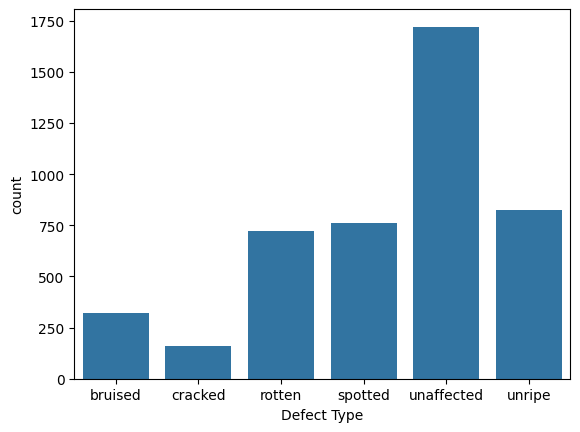

In [14]:
# Petite observation sur la distribution des classes
import seaborn as sns
sns.countplot(x='Defect Type', data=df_plums)

### Déséquilibre des classes

Dès l’analyse initiale du dataset, on remarque un **déséquilibre flagrant entre les classes**. Par exemple, la classe `unaffected` contient un grand nombre d’images comparée aux classes comme `cracked` ou `bruised`.

Ce déséquilibre peut poser de sérieux problèmes durant l'entraînement. En effet, le modèle aura tendance à prédire la classe majoritaire pour maximiser sa **précision globale**, sans réellement apprendre à reconnaître les classes minoritaires.

>  **Conséquence :** le modèle devient **biaisé** et **inefficace** pour les catégories sous-représentées, comme `cracked` et `bruised`.


### Stratégies pour gérer le déséquilibre

Afin d’améliorer la qualité de l’apprentissage, **deux techniques complémentaires** peuvent etre employé :


#### 1. Pondération de la fonction de perte (`Weighted CrossEntropyLoss`)

L’idée est d’**attribuer un poids plus important aux classes rares** dans la fonction de perte. Ainsi, une mauvaise prédiction sur `cracked` ou `bruised` aura un impact plus fort sur la perte que pour `unaffected`.

> Résultat : le modèle prend mieux en compte les classes sous-représentées pendant l'entraînement.


#### 2. Augmentation des données (`Data Augmentation`)

La deuxième solution consiste à **augmenter artificiellement la taille des classes minoritaires**. Pour cela, des transformations ont été appliquées aux images existantes (`rotation`, `flip`, `color jitter`, etc.) pour générer de nouvelles images réalistes.

> Objectif : **équilibrer le nombre d’images** dans chaque classe, en visant le même nombre que la classe majoritaire (`unaffected` = 1721 images).


> En combinant ces deux approches, nous pouvons **réduire significativement le biais du modèle**, et permettre un apprentissage plus équilibré entre les différentes classes.

#### Cas de l'Augmentation des données (`Data Augmentation`)

In [3]:
# Le script d'augmentation/génération d'image se trouve dans le dossiers script du projet
# /scripts/data_augmentation.py

#### Cas de la Pondération de la fonction de perte (`Weighted CrossEntropyLoss`)

In [16]:
import torch

# Nouvelles occurrences par classe
occ_classes_updated = {
    'bruised': 1721,
    'cracked': 800,
    'rotten': 1721,
    'spotted': 1721,
    'unaffected': 1721,
    'unripe': 1721,
}

# Liste ordonnée des classes
classes = ['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']
occurences = torch.tensor([occ_classes_updated[classe] for classe in classes], dtype=torch.float32)

# Calcul des poids inverses
poids = 1.0 / occurences
poids = poids / poids.sum()

print("Poids à utiliser dans CrossEntropyLoss :", poids)


Poids à utiliser dans CrossEntropyLoss : tensor([0.1398, 0.3008, 0.1398, 0.1398, 0.1398, 0.1398])


### Préparation du dossier des images
Il s'agit ici de la structure ImageFolder attendue par PyTorch
```txt
Dossier: african_plums/
 ├── bruised/
 ├── cracked/
 ├── rotten/
 ├── spotted/
 ├── unaffected/
 └── unripe/
```

#### Transformation et Dataset Personnalisé

In [17]:
# Definition de la transformation a appliquer sur les images pour l'entrainement et la validation
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import os

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


# Charger le dataset avec ImageFolder
dataset = ImageFolder(root=images_path, transform=transform)
# On verifie que les images sont bien chargees
print(dataset.classes)

# Séparation du dataset en train, validation et test (70, 15, 15)
# configuration des tailles de chaque jeux de données
taille_total = len(dataset)
taille_entrainement = int(0.7 * taille_total)
taille_validation = int(0.15 * taille_total)
taille_test = taille_total - taille_entrainement - taille_validation # on aura donc egalement 15% pour les tests

# séparation proprement dite du dataset
entrainement_dataset, validation_dataset, test_dataset = random_split(dataset, [taille_entrainement, taille_validation, taille_test])

entrainement_loader = DataLoader(entrainement_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']


#### Tranfert learning & Entrainement du modele avec ResNet

In [19]:
# Verifions si Google Collab a un GPU activé...
import torch
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun GPU")

GPU disponible : True
Nom du GPU : Tesla T4


In [20]:
# Essayons de charger un modele pre-entrainé et de l'adapter a notre dataset
from torch import nn

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6) # car nous avons 6 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # pour que notre modele s'entraine automatiquement sur GPU...
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


✅ Époque 1/10 terminée | Accuracy Entrainement: 50.33% | Accuracy Valalidation: 52.62% | Perte: 1.2871


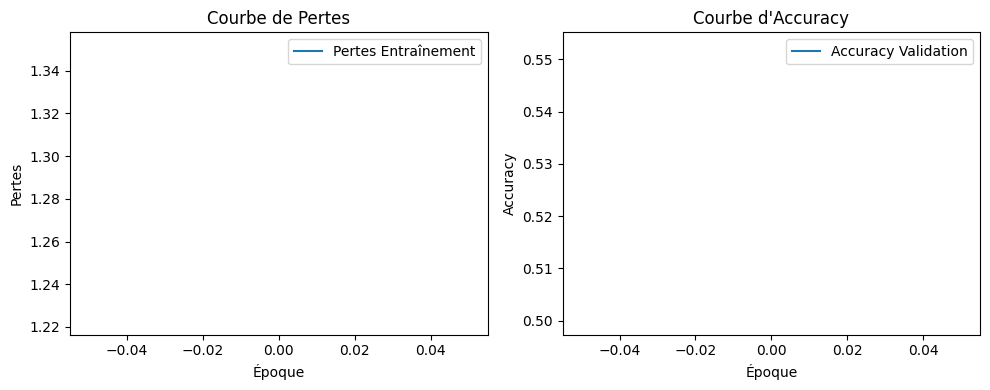

✅ Époque 2/10 terminée | Accuracy Entrainement: 59.87% | Accuracy Valalidation: 60.43% | Perte: 1.0489


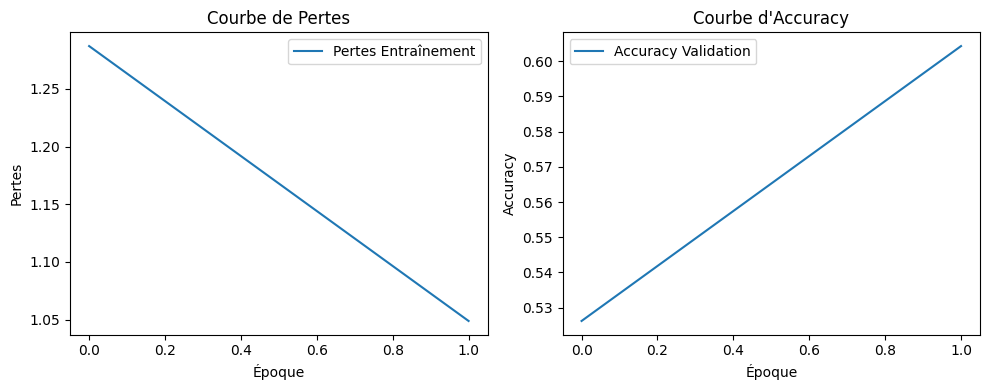

✅ Époque 3/10 terminée | Accuracy Entrainement: 65.12% | Accuracy Valalidation: 58.65% | Perte: 0.9051


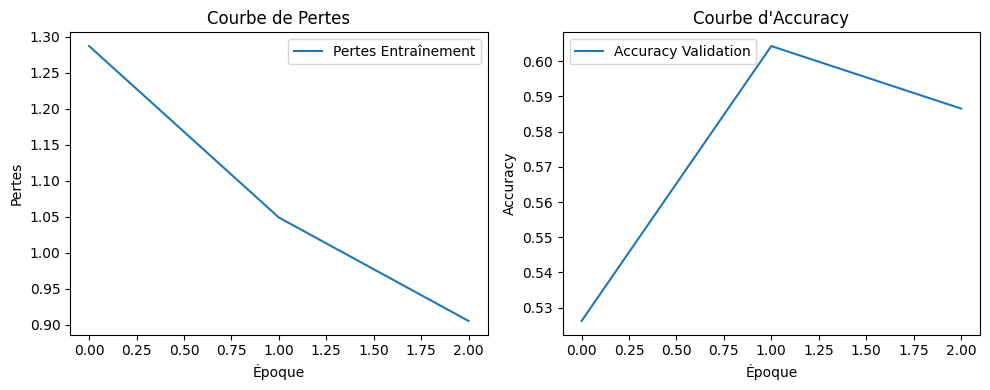

✅ Époque 4/10 terminée | Accuracy Entrainement: 69.41% | Accuracy Valalidation: 54.47% | Perte: 0.7901


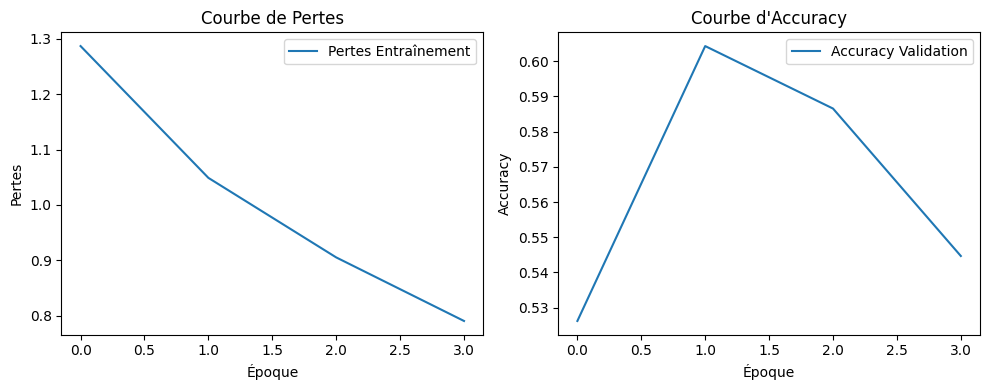

✅ Époque 5/10 terminée | Accuracy Entrainement: 72.88% | Accuracy Valalidation: 59.08% | Perte: 0.6994


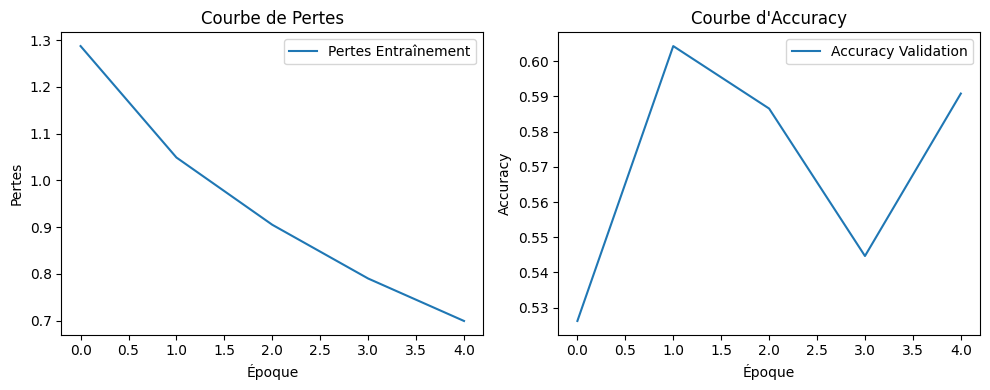

✅ Époque 6/10 terminée | Accuracy Entrainement: 76.30% | Accuracy Valalidation: 68.09% | Perte: 0.6206


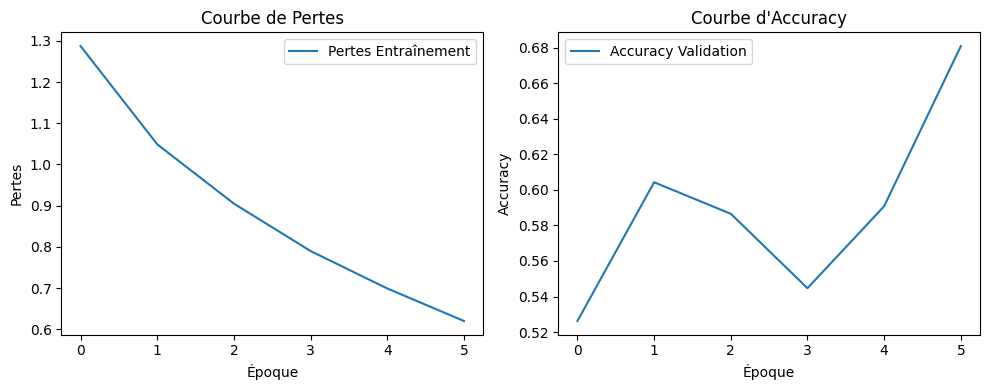

✅ Époque 7/10 terminée | Accuracy Entrainement: 81.50% | Accuracy Valalidation: 57.80% | Perte: 0.5035


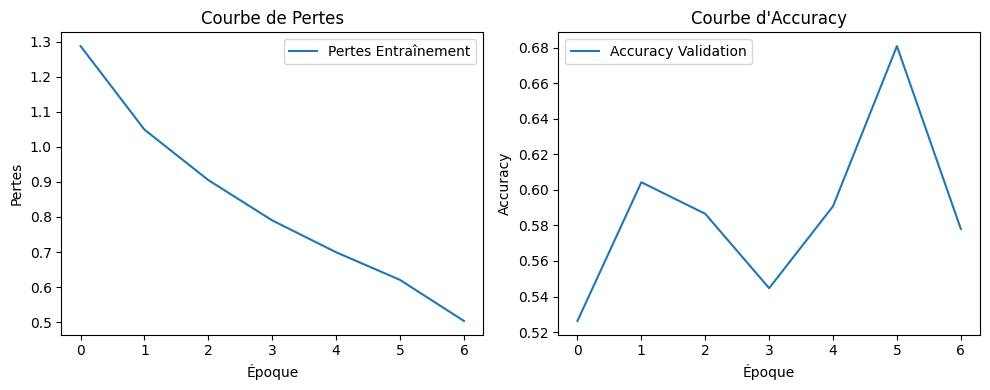

✅ Époque 8/10 terminée | Accuracy Entrainement: 84.52% | Accuracy Valalidation: 65.60% | Perte: 0.4167


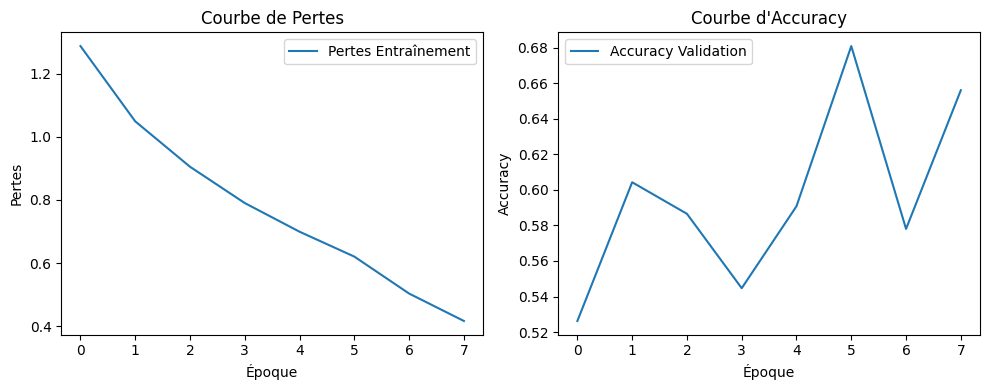

✅ Époque 9/10 terminée | Accuracy Entrainement: 86.80% | Accuracy Valalidation: 65.46% | Perte: 0.3624


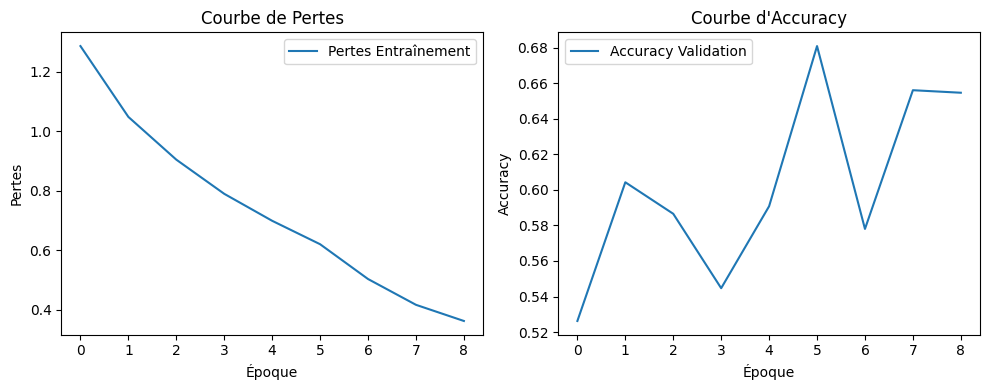

✅ Époque 10/10 terminée | Accuracy Entrainement: 89.96% | Accuracy Valalidation: 65.46% | Perte: 0.2870


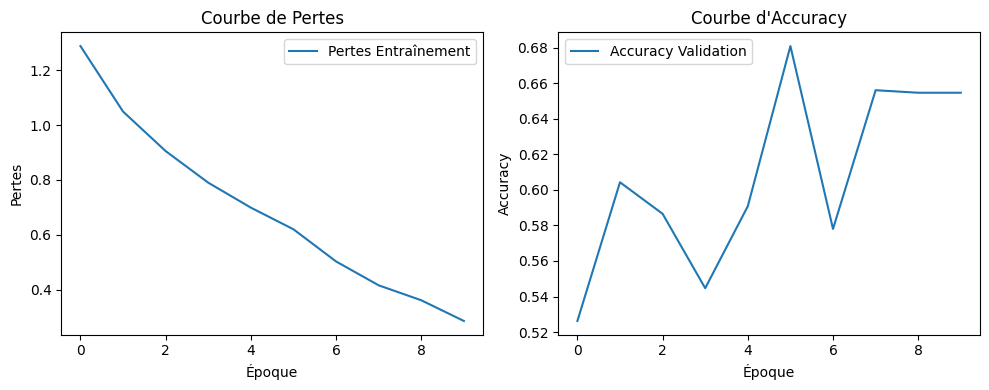

In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm

poids = poids.to(device)
criterion = nn.CrossEntropyLoss(weight=poids)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# les listes pour stocker les valeurs par époque
# qui nous permettrons d'afficher les graphiques de perte et d'accuracy par la suite
pertes_train = []
accuracy_validation = []

for epoch in range(10):
    model.train()
    perte_courante = 0.0
    correct = 0
    total = 0

    boucle_train = tqdm(entrainement_loader, desc=f"Époque {epoch+1}", leave=False) # pour dessiner une barre de progression en temps réel

    for images, classes in boucle_train:
        images, classes = images.to(device), classes.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        pertes = criterion(predictions, classes)
        pertes.backward()
        optimizer.step()

        perte_courante += pertes.item()
        _, pred_classes = torch.max(predictions, 1)
        correct += (pred_classes == classes).sum().item()
        total += classes.size(0)

        boucle_train.set_postfix(perte=pertes.item(), précision=100 * correct / total)

    perte_moyenne = perte_courante / len(entrainement_loader)
    pertes_train.append(perte_moyenne)

    # Évaluation apres chaque entrainement pour une validation
    model.eval()
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, classes in validation_loader:
            images, classes = images.to(device), classes.to(device)
            predictions = model(images)
            _, pred_classes = torch.max(predictions, 1)
            correct_val += (pred_classes == classes).sum().item()
            total_val += classes.size(0)

    accuracy = correct/total
    accuracy_val = correct_val/total_val
    accuracy_validation.append(accuracy_val)

    print(f"✅ Époque {epoch+1}/10 terminée | Accuracy Entrainement: {100*accuracy:.2f}% | Accuracy Valalidation: {100*accuracy_val:.2f}% | Perte: {perte_moyenne:.4f}")

    # Affichage du graphique pour visualiser les performances de l'itération actuelle
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(pertes_train, label='Pertes Entraînement')
    plt.xlabel('Époque')
    plt.ylabel('Pertes')
    plt.title('Courbe de Pertes')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_validation, label='Accuracy Validation')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.title("Courbe d'Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


### Remarque :
On peut donc voir que l'entrainement de notre modele se termine avec :
- Accuracy d'entrainement : 89.96%
- Accuracy de validation : 65.46%

Ce qui est un apprentissage remarquable sachant que nous avons commencé a l'epoque  1 avec :     
- Accuracy d'entrainement : 50.33.96%
- Accuracy de validation : 52.62%

### Sauvegarde du modele pour le service backend

In [26]:
# Sauvegarde du meilleur model avec la perte la plus basse
sauvegarde_path = "/content/drive/MyDrive/JCIA/dataset/classeur_de_prunes_v4.pt"
torch.save(model, sauvegarde_path)

### Evaluation du modele avec nos données de test

In [23]:
# Recharger le modèle entraîné
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 6)  # 6 classes
model.load_state_dict(torch.load(sauvegarde_path))
model = model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluation complete avec métrique et matrice de confusion
On va calculer :
- Acccuracy
- Precision
- Recall
- F1-score
- matrice de confusion

Rapport de classification :

              precision    recall  f1-score   support

     bruised       0.55      0.43      0.48       247
     cracked       0.49      0.75      0.60       130
      rotten       0.83      0.57      0.68       274
     spotted       0.44      0.61      0.51       243
  unaffected       0.85      0.81      0.83       268
      unripe       0.77      0.74      0.75       250

    accuracy                           0.65      1412
   macro avg       0.66      0.65      0.64      1412
weighted avg       0.68      0.65      0.65      1412



<Figure size 800x600 with 0 Axes>

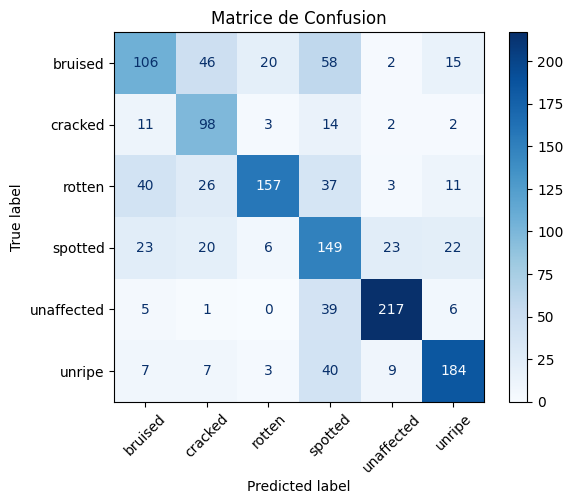

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, classes in test_loader:
        images, classes = images.to(device), classes.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(classes.cpu().numpy())

# Rapport de classification
print("Rapport de classification :\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matrice de Confusion")
plt.grid(False)
plt.show()


## Conclusion & Analyse Finale du Modèle

Le modèle final présente une **précision globale de 65%** sur l'ensemble de données de test, ce qui est **encourageant** compte tenu de la diversité des défauts à reconnaître et du déséquilibre initial des classes.

### Analyse de la Matrice de Confusion :
L’analyse de la **matrice de confusion** révèle que certaines classes sont souvent **confondues entre elles**, notamment :
- **Spotted** et **Bruised**, qui ont des caractéristiques visuelles parfois proches, sont souvent confondues l’une avec l’autre.
- Quelques cas de **cracked** sont mal classés comme **rotten**, probablement à cause de zones sombres ou endommagées similaires.
- Très peu de confusion entre **unaffected** et les autres classes, ce qui montre que les prunes saines sont bien identifiées.

La matrice permet donc de **valider visuellement les faiblesses du modèle**, et oriente vers des pistes d’amélioration ciblées (ex. : focus sur la différenciation de bruised vs spotted).

### Analyse par classe :

- **Unripe (74%)** et **Unaffected (81%)** sont très bien détectées, ce qui montre que les caractéristiques visuelles de ces classes sont bien apprises par le modèle.
- **Cracked (75% recall)** est aussi bien détectée, même si la précision est plus basse (49%), ce qui suggère quelques faux positifs.
- **Rotten (83% précision)** montre une forte capacité du modèle à l’identifier correctement lorsqu’il le prédit, bien qu’il en rate encore une partie (57% recall).
- **Spotted** et **Bruised** sont les classes les plus difficiles à bien classer. Cela peut s'expliquer par :
  - leur apparence visuelle plus subtile ou variable,
  - un manque relatif de données d'entraînement pour ces catégories.

### En résumé :

Le modèle est **fiable pour détecter les prunes saines ou très endommagées**, ce qui est souvent crucial dans des cas industriels ou commerciaux.
---

**Ce modèle constitue donc la version finale retenue**. Il est désormais prêt à être **intégré dans une API Flask** et connecté à une interface Web pour une démo complète et interactive du classificateur de prunes.
